# Connect4 CNN Training - NO DATA LEAKAGE VERSION

This notebook trains a CNN to play Connect4 with proper train/val splitting to prevent data leakage.

**Key Fix**: Data is split BEFORE augmentation, then each set is augmented separately.

## Step 1: Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pickle
import time

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available: []


## Step 2: Data Loading

**CRITICAL ORDER:**
1. Load data
2. Convert to 6x7x2 encoding
3. **SPLIT first** (train/val)
4. **THEN augment each set separately**

In [2]:
# ==================== PREPROCESSING FOR CHECKPOINT DATA ====================
# This handles data from colab_data_generation_FAST.py checkpoints
# Uses game_id metadata for proper game-level splitting

from sklearn.model_selection import train_test_split

def load_checkpoint_data(filepath, test_size=0.2):
    """
    Load checkpoint .pkl from colab_data_generation_FAST.py
    
    CRITICAL: This script uses 'canonical' perspective — 
    Ch0 = current player, Ch1 = opponent.
    The CNN must match this convention during gameplay.
    """
    import pickle
    
    with open(filepath, 'rb') as f:
        all_data = pickle.load(f)
    
    print(f"Loaded {len(all_data):,} samples from checkpoint")
    
    # Extract arrays
    X = np.array([board for board, move, meta in all_data], dtype=np.float32)
    y = np.array([move for board, move, meta in all_data], dtype=np.int64)
    game_ids = np.array([meta['game_id'] for board, move, meta in all_data])
    
    print(f"X: {X.shape}, y: {y.shape}")
    print(f"Unique games: {len(np.unique(game_ids)):,}")
    
    # ===== SPLIT BY GAME (no leakage) =====
    unique_games = np.unique(game_ids)
    train_game_ids, val_game_ids = train_test_split(
        unique_games, test_size=test_size, random_state=42
    )
    
    train_mask = np.isin(game_ids, train_game_ids)
    val_mask = np.isin(game_ids, val_game_ids)
    
    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[val_mask], y[val_mask]
    
    print(f"\nSplit by game (no leakage):")
    print(f"  Train: {len(X_train):,} positions from {len(train_game_ids):,} games")
    print(f"  Val:   {len(X_val):,} positions from {len(val_game_ids):,} games")
    
    # ===== AUGMENT: horizontal flip (AFTER splitting) =====
    X_train_flip = X_train[:, :, ::-1, :].copy()
    y_train_flip = 6 - y_train
    X_train = np.concatenate([X_train, X_train_flip])
    y_train = np.concatenate([y_train, y_train_flip])
    
    X_val_flip = X_val[:, :, ::-1, :].copy()
    y_val_flip = 6 - y_val
    X_val = np.concatenate([X_val, X_val_flip])
    y_val = np.concatenate([y_val, y_val_flip])
    
    # Shuffle
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]
    idx = np.random.permutation(len(X_val))
    X_val, y_val = X_val[idx], y_val[idx]
    
    print(f"\nAfter augmentation (horizontal flip):")
    print(f"  Train: {len(X_train):,}")
    print(f"  Val:   {len(X_val):,}")
    
    return X_train, X_val, y_train, y_val

print("Preprocessing function ready.")


Preprocessing function ready.


## Step 3: Model Architecture

In [3]:
def build_cnn_robust(input_shape=(6, 7, 2)):
    """
    Robust CNN for Connect4
    ~2M parameters
    """
    
    inputs = keras.Input(shape=input_shape)
    
    # Conv Block 1
    x = layers.Conv2D(64, (4, 4), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (4, 4), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Conv Block 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Conv Block 3
    x = layers.Conv2D(256, (2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # Output
    outputs = layers.Dense(7, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='connect4_cnn_robust')
    return model

## Step 4: Load Data



In [4]:
# ===== CONFIGURATION =====
DATA_PATH = r'C:\Users\Andy\fast_10k_checkpoint_32000.pkl'  # ← CHANGE THIS to your latest checkpoint

# Load and preprocess (NO LEAKAGE — splits by game)
X_train, X_val, y_train, y_val = load_checkpoint_data(DATA_PATH, test_size=0.2)

print("\n✓ Data ready for training!")
print(f"Train shape: X={X_train.shape}, y={y_train.shape}")
print(f"Val shape:   X={X_val.shape}, y={y_val.shape}")


Loaded 970,730 samples from checkpoint
X: (970730, 6, 7, 2), y: (970730,)
Unique games: 32,000

Split by game (no leakage):
  Train: 777,274 positions from 25,600 games
  Val:   193,456 positions from 6,400 games

After augmentation (horizontal flip):
  Train: 1,554,548
  Val:   386,912

✓ Data ready for training!
Train shape: X=(1554548, 6, 7, 2), y=(1554548,)
Val shape:   X=(386912, 6, 7, 2), y=(386912,)


## Step 5: Build Model

In [5]:
model = build_cnn_robust(input_shape=X_train.shape[1:])
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")

Model: "connect4_cnn_robust"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 6, 7, 64)       │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 7, 64)       │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 256)      │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,002,823 (7.64 MB)

 Trainable params: 1,999,495 (7.63 MB)

 Non-trainable params: 3,328 (13.00 KB)


Total parameters: 2,002,823


## Step 6: Compile Model

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model compiled")

✓ Model compiled


## Step 7: Setup Callbacks

In [7]:
callbacks = [
    # Reduce learning rate when stuck
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Stop if no improvement
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model
    keras.callbacks.ModelCheckpoint(
        'connect4_cnn_NO_LEAKAGE_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Callbacks configured")

✓ Callbacks configured


## Step 8: Train Model



In [8]:
print("\n" + "="*60)
print("TRAINING (NO LEAKAGE VERSION)")
print("="*60)
print(f"Train: {len(X_train):,} positions")
print(f"Val:   {len(X_val):,} positions")
print(f"Batch size: 128")
print(f"Max epochs: 50")
print("="*60 + "\n")

start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # ← NOT validation_split!
    batch_size=128,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes")


TRAINING (NO LEAKAGE VERSION)
Train: 1,554,548 positions
Val:   386,912 positions
Batch size: 128
Max epochs: 50

Epoch 1/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4315 - loss: 1.7769
Epoch 1: val_accuracy improved from None to 0.61116, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 266s 22ms/step - accuracy: 0.5137 - loss: 1.4023 - val_accuracy: 0.6112 - val_loss: 1.0926 - learning_rate: 0.0010
Epoch 2/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5962 - loss: 1.1330
Epoch 2: val_accuracy improved from 0.61116 to 0.63972, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6035 - loss: 1.1124 - val_accuracy: 0.6397 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 3/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6224 - loss: 1.0531
Epoch 3: val_accuracy improved from 0.63972 to 0.65387, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6250 - loss: 1.0424 - val_accuracy: 0.6539 - val_loss: 0.9405 - learning_rate: 0.0010
Epoch 4/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6373 - loss: 1.0033
Epoch 4: val_accuracy improved from 0.65387 to 0.66579, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6374 - loss: 0.9992 - val_accuracy: 0.6658 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 5/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6450 - loss: 0.9741
Epoch 5: val_accuracy improved from 0.66579 to 0.67554, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6458 - loss: 0.9719 - val_accuracy: 0.6755 - val_loss: 0.8792 - learning_rate: 0.0010
Epoch 6/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6508 - loss: 0.9548
Epoch 6: val_accuracy improved from 0.67554 to 0.67576, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6512 - loss: 0.9535 - val_accuracy: 0.6758 - val_loss: 0.8757 - learning_rate: 0.0010
Epoch 7/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6573 - loss: 0.9386
Epoch 7: val_accuracy improved from 0.67576 to 0.68319, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 266s 22ms/step - accuracy: 0.6568 - loss: 0.9400 - val_accuracy: 0.6832 - val_loss: 0.8581 - learning_rate: 0.0010
Epoch 8/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6617 - loss: 0.9276
Epoch 8: val_accuracy improved from 0.68319 to 0.68679, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 266s 22ms/step - accuracy: 0.6605 - loss: 0.9293 - val_accuracy: 0.6868 - val_loss: 0.8439 - learning_rate: 0.0010
Epoch 9/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6644 - loss: 0.9190
Epoch 9: val_accuracy improved from 0.68679 to 0.68710, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6640 - loss: 0.9203 - val_accuracy: 0.6871 - val_loss: 0.8418 - learning_rate: 0.0010
Epoch 10/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6672 - loss: 0.9115
Epoch 10: val_accuracy improved from 0.68710 to 0.68948, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6674 - loss: 0.9122 - val_accuracy: 0.6895 - val_loss: 0.8401 - learning_rate: 0.0010
Epoch 11/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6703 - loss: 0.9036
Epoch 11: val_accuracy improved from 0.68948 to 0.69235, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 265s 22ms/step - accuracy: 0.6692 - loss: 0.9068 - val_accuracy: 0.6923 - val_loss: 0.8310 - learning_rate: 0.0010
Epoch 12/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6721 - loss: 0.8982
Epoch 12: val_accuracy improved from 0.69235 to 0.69235, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 266s 22ms/step - accuracy: 0.6714 - loss: 0.9004 - val_accuracy: 0.6924 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 13/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6740 - loss: 0.8930
Epoch 13: val_accuracy improved from 0.69235 to 0.69375, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 266s 22ms/step - accuracy: 0.6735 - loss: 0.8955 - val_accuracy: 0.6937 - val_loss: 0.8268 - learning_rate: 0.0010
Epoch 14/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6761 - loss: 0.8884
Epoch 14: val_accuracy improved from 0.69375 to 0.69673, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6752 - loss: 0.8908 - val_accuracy: 0.6967 - val_loss: 0.8223 - learning_rate: 0.0010
Epoch 15/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6784 - loss: 0.8831
Epoch 15: val_accuracy improved from 0.69673 to 0.69824, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6771 - loss: 0.8866 - val_accuracy: 0.6982 - val_loss: 0.8161 - learning_rate: 0.0010
Epoch 16/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6793 - loss: 0.8792
Epoch 16: val_accuracy improved from 0.69824 to 0.69918, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6784 - loss: 0.8820 - val_accuracy: 0.6992 - val_loss: 0.8182 - learning_rate: 0.0010
Epoch 17/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6810 - loss: 0.8756
Epoch 17: val_accuracy improved from 0.69918 to 0.70172, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6798 - loss: 0.8790 - val_accuracy: 0.7017 - val_loss: 0.8095 - learning_rate: 0.0010
Epoch 18/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6816 - loss: 0.8736
Epoch 18: val_accuracy improved from 0.70172 to 0.70267, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6810 - loss: 0.8751 - val_accuracy: 0.7027 - val_loss: 0.8055 - learning_rate: 0.0010
Epoch 19/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6838 - loss: 0.8699
Epoch 19: val_accuracy did not improve from 0.70267
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6828 - loss: 0.8721 - val_accuracy: 0.7008 - val_loss: 0.8085 - learning_rate: 0.0010
Epoch 20/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6839 - loss: 0.8677
Epoch 20: val_accuracy improved from 0.70267 to 0.70426, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6830 - loss: 0.8695 - val_accuracy: 0.7043 - val_loss: 0.8008 - learning_rate: 0.0010
Epoch 21/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6846 - loss: 0.8656
Epoch 21: val_accuracy did not improve from 0.70426
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6838 - loss: 0.8675 - val_accuracy: 0.7029 - val_loss: 0.8057 - learning_rate: 0.0010
Epoch 22/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6856 - loss: 0.8629
Epoch 22: val_accuracy improved from 0.70426 to 0.70487, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6850 - loss: 0.8643 - val_accuracy: 0.7049 - val_loss: 0.8016 - learning_rate: 0.0010
Epoch 23/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6866 - loss: 0.8594
Epoch 23: val_accuracy improved from 0.70487 to 0.70742, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6857 - loss: 0.8631 - val_accuracy: 0.7074 - val_loss: 0.7930 - learning_rate: 0.0010
Epoch 24/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6876 - loss: 0.8579
Epoch 24: val_accuracy did not improve from 0.70742
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6865 - loss: 0.8601 - val_accuracy: 0.7020 - val_loss: 0.8058 - learning_rate: 0.0010
Epoch 25/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6883 - loss: 0.8568
Epoch 25: val_accuracy improved from 0.70742 to 0.70850, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6873 - loss: 0.8588 - val_accuracy: 0.7085 - val_loss: 0.7935 - learning_rate: 0.0010
Epoch 26/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6898 - loss: 0.8537
Epoch 26: val_accuracy improved from 0.70850 to 0.70952, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6880 - loss: 0.8570 - val_accuracy: 0.7095 - val_loss: 0.7900 - learning_rate: 0.0010
Epoch 27/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6906 - loss: 0.8508
Epoch 27: val_accuracy did not improve from 0.70952
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6894 - loss: 0.8543 - val_accuracy: 0.7089 - val_loss: 0.7902 - learning_rate: 0.0010
Epoch 28/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6908 - loss: 0.8495
Epoch 28: val_accuracy did not improve from 0.70952
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6900 - loss: 0.8521 - val_accuracy: 0.7088 - val_loss: 0.7929 - learning_rate: 0.0010
Epoch 29/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6909 - loss: 0.8493
Epoch 29: val_accuracy did not improve from 0.70952
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6903 - loss: 0.8512 - val_accuracy: 0.7080 - val_loss: 0.7918 

12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6912 - loss: 0.8495 - val_accuracy: 0.7102 - val_loss: 0.7866 - learning_rate: 0.0010
Epoch 31/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6931 - loss: 0.8424
Epoch 31: val_accuracy did not improve from 0.71018
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6914 - loss: 0.8466 - val_accuracy: 0.7073 - val_loss: 0.7890 - learning_rate: 0.0010
Epoch 32/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6932 - loss: 0.8434
Epoch 32: val_accuracy improved from 0.71018 to 0.71250, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6920 - loss: 0.8462 - val_accuracy: 0.7125 - val_loss: 0.7827 - learning_rate: 0.0010
Epoch 33/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6932 - loss: 0.8435
Epoch 33: val_accuracy did not improve from 0.71250
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 270s 22ms/step - accuracy: 0.6928 - loss: 0.8450 - val_accuracy: 0.7115 - val_loss: 0.7850 - learning_rate: 0.0010
Epoch 34/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6943 - loss: 0.8406
Epoch 34: val_accuracy did not improve from 0.71250
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 272s 22ms/step - accuracy: 0.6931 - loss: 0.8435 - val_accuracy: 0.7092 - val_loss: 0.7881 - learning_rate: 0.0010
Epoch 35/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6943 - loss: 0.8406
Epoch 35: val_accuracy did not improve from 0.71250
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6933 - loss: 0.8432 - val_accuracy: 0.7111 - val_loss: 0.7833 

12145/12145 ━━━━━━━━━━━━━━━━━━━━ 270s 22ms/step - accuracy: 0.6943 - loss: 0.8409 - val_accuracy: 0.7125 - val_loss: 0.7803 - learning_rate: 0.0010
Epoch 37/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6968 - loss: 0.8371
Epoch 37: val_accuracy did not improve from 0.71254
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 271s 22ms/step - accuracy: 0.6954 - loss: 0.8392 - val_accuracy: 0.7104 - val_loss: 0.7818 - learning_rate: 0.0010
Epoch 38/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6960 - loss: 0.8359
Epoch 38: val_accuracy did not improve from 0.71254
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 273s 22ms/step - accuracy: 0.6953 - loss: 0.8378 - val_accuracy: 0.7117 - val_loss: 0.7826 - learning_rate: 0.0010
Epoch 39/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6966 - loss: 0.8342
Epoch 39: val_accuracy improved from 0.71254 to 0.71395, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 272s 22ms/step - accuracy: 0.6954 - loss: 0.8370 - val_accuracy: 0.7140 - val_loss: 0.7775 - learning_rate: 0.0010
Epoch 40/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6972 - loss: 0.8343
Epoch 40: val_accuracy did not improve from 0.71395
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 273s 22ms/step - accuracy: 0.6966 - loss: 0.8358 - val_accuracy: 0.7127 - val_loss: 0.7789 - learning_rate: 0.0010
Epoch 41/50
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6975 - loss: 0.8324
Epoch 41: val_accuracy did not improve from 0.71395
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 270s 22ms/step - accuracy: 0.6968 - loss: 0.8352 - val_accuracy: 0.7132 - val_loss: 0.7757 - learning_rate: 0.0010
Epoch 42/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6979 - loss: 0.8310
Epoch 42: val_accuracy improved from 0.71395 to 0.71492, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6968 - loss: 0.8341 - val_accuracy: 0.7149 - val_loss: 0.7765 - learning_rate: 0.0010
Epoch 43/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6979 - loss: 0.8310
Epoch 43: val_accuracy did not improve from 0.71492
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 271s 22ms/step - accuracy: 0.6971 - loss: 0.8335 - val_accuracy: 0.7147 - val_loss: 0.7746 - learning_rate: 0.0010
Epoch 44/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6982 - loss: 0.8290
Epoch 44: val_accuracy did not improve from 0.71492
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.6977 - loss: 0.8314 - val_accuracy: 0.7116 - val_loss: 0.7819 - learning_rate: 0.0010
Epoch 45/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6992 - loss: 0.8276
Epoch 45: val_accuracy did not improve from 0.71492
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 268s 22ms/step - accuracy: 0.6981 - loss: 0.8304 - val_accuracy: 0.7108 - val_loss: 0.7827 

12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6984 - loss: 0.8296 - val_accuracy: 0.7154 - val_loss: 0.7721 - learning_rate: 0.0010
Epoch 48/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7008 - loss: 0.8246
Epoch 48: val_accuracy improved from 0.71540 to 0.71744, saving model to connect4_cnn_NO_LEAKAGE_best.h5


12145/12145 ━━━━━━━━━━━━━━━━━━━━ 266s 22ms/step - accuracy: 0.6994 - loss: 0.8282 - val_accuracy: 0.7174 - val_loss: 0.7681 - learning_rate: 0.0010
Epoch 49/50
12144/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6999 - loss: 0.8250
Epoch 49: val_accuracy did not improve from 0.71744
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6991 - loss: 0.8279 - val_accuracy: 0.7149 - val_loss: 0.7734 - learning_rate: 0.0010
Epoch 50/50
12143/12145 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7004 - loss: 0.8242
Epoch 50: val_accuracy did not improve from 0.71744
12145/12145 ━━━━━━━━━━━━━━━━━━━━ 267s 22ms/step - accuracy: 0.6997 - loss: 0.8267 - val_accuracy: 0.7132 - val_loss: 0.7776 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 48.

Training completed in 223.5 minutes


## Step 9: Save Final Model

In [9]:
model.save('model_cnn_NO_LEAKAGE_final.h5')
model.save('model_cnn_NO_LEAKAGE_final.keras')



## Step 10: Evaluate

Check final accuracy on validation set

In [10]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Validation Loss:     {val_loss:.4f}")
print("="*60)

print("\nExpected results with NO LEAKAGE:")
print("  - Validation accuracy: 75-80% (REAL accuracy)")
print("  - Should beat 500-step MCTS: 80-90% win rate")
print("\nNext: Test against MCTS to see real performance!")


FINAL RESULTS
Validation Accuracy: 0.7174 (71.74%)
Validation Loss:     0.7681

Expected results with NO LEAKAGE:
  - Validation accuracy: 75-80% (REAL accuracy)
  - Should beat 500-step MCTS: 80-90% win rate

Next: Test against MCTS to see real performance!


## Step 11: Test CNN vs MCTS

Play actual games against MCTS to measure **real game performance**.

This is the true test — validation accuracy tells you how well the model predicts MCTS labels,
but win rate tells you how well it actually **plays**.

In [11]:
# ==================== GAME ENGINE (from run_parallel.py) ====================
import random

def update_board(board_temp, color, column):
    board = board_temp.copy()
    colsum = abs(board[0,column])+abs(board[1,column])+abs(board[2,column])+abs(board[3,column])+abs(board[4,column])+abs(board[5,column])
    row = int(5-colsum)
    if row > -0.5:
        if color == 'plus':
            board[row,column] = 1
        else:
            board[row,column] = -1
    return board

def check_for_win(board, col):
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4: return 'v-plus'
        elif vert == -4: return 'v-minus'
    
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4: return 'h-plus'
        elif hor == -4: return 'h-minus'
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4: return 'h-plus'
        elif hor == -4: return 'h-minus'
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4: return 'h-plus'
        elif hor == -4: return 'h-minus'
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4: return 'h-plus'
        elif hor == -4: return 'h-minus'
    
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4: return 'd-plus'
        elif DR == -4: return 'd-minus'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4: return 'd-plus'
        elif DR == -4: return 'd-minus'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4: return 'd-plus'
        elif DR == -4: return 'd-minus'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4: return 'd-plus'
        elif DR == -4: return 'd-minus'
    
    if row < 3 and col >= 3:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4: return 'd-plus'
        elif DL == -4: return 'd-minus'
    if row-1>=0 and col+1<7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4: return 'd-plus'
        elif DL == -4: return 'd-minus'
    if row-2>=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4: return 'd-plus'
        elif DL == -4: return 'd-minus'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4: return 'd-plus'
        elif DL == -4: return 'd-minus'
    
    return 'nobody'

def find_legal(board):
    legal = []
    for col in range(7):
        if board[0,col] == 0:
            legal.append(col)
    return legal

def look_for_win(board, color):
    legal = find_legal(board)
    for col in legal:
        board_temp = update_board(board, color, col)
        winner = check_for_win(board_temp, col)
        if winner[2] == color[0]:
            return col
    return -1

def find_all_nonlosers(board, color):
    legal = find_legal(board)
    opponent = 'minus' if color == 'plus' else 'plus'
    safe = []
    for col in legal:
        board_temp = update_board(board, color, col)
        opp_win = look_for_win(board_temp, opponent)
        if opp_win < 0:
            safe.append(col)
    return safe

def rollout(board_temp, color0):
    winner = 'nobody'
    color = color0
    board = board_temp.copy()
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            winner = 'tie'
            break
        col = random.choice(legal)
        board = update_board(board, color, col)
        winner = check_for_win(board, col)
        color = 'minus' if color == 'plus' else 'plus'
    return winner

def back_prop(winner, path, color0, mcts_dict):
    for board_tuple in path:
        mcts_dict[board_tuple][0] += 1
        if winner[2] == color0[0]:
            mcts_dict[board_tuple][1] += 1

def mcts(board_temp, color0, nsteps):
    board = board_temp.copy()
    winColumn = look_for_win(board, color0)
    if winColumn > -0.5:
        return winColumn
    legal0 = find_all_nonlosers(board, color0)
    if len(legal0) == 0:
        legal0 = find_legal(board)
    mcts_dict = {tuple(board.ravel()): [0, 0]}
    for ijk in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner, path, color0, mcts_dict)
                break
            board_list = [tuple(update_board(board_mcts, color, col).ravel()) for col in legal]
            for bl in board_list:
                if bl not in mcts_dict:
                    mcts_dict[bl] = [0, 0]
            ucb1 = np.zeros(len(legal))
            for i in range(len(legal)):
                num_denom = mcts_dict[board_list[i]]
                if num_denom[0] == 0:
                    ucb1[i] = 10 * nsteps
                else:
                    ucb1[i] = num_denom[1]/num_denom[0] + 2*np.sqrt(np.log(mcts_dict[path[-1]][0])/mcts_dict[board_list[i]][0])
            chosen = np.argmax(ucb1)
            board_mcts = update_board(board_mcts, color, legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            winner = check_for_win(board_mcts, legal[chosen])
            if winner[2] == color[0]:
                back_prop(winner, path, color0, mcts_dict)
                break
            color = 'minus' if color == 'plus' else 'plus'
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner = rollout(board_mcts, color)
                back_prop(winner, path, color0, mcts_dict)
                break
    maxval = -np.inf
    best_col = -1
    for col in legal0:
        board_temp = tuple(update_board(board, color0, col).ravel())
        num_denom = mcts_dict[board_temp]
        if num_denom[0] == 0:
            compare = -np.inf
        else:
            compare = num_denom[1] / num_denom[0]
        if compare > maxval:
            maxval = compare
            best_col = col
    return best_col

print('Game engine loaded.')

Game engine loaded.


In [12]:
# ==================== CNN PLAYER ====================
# IMPORTANT: colab_data_generation_FAST.py uses CANONICAL perspective:
#   Channel 0 = current player's pieces
#   Channel 1 = opponent's pieces
# So we encode the board the same way during gameplay.

def board_to_canonical(board, player):
    """Convert (6,7) board to (1, 6, 7, 2) in canonical perspective.
    Ch0 = current player, Ch1 = opponent."""
    encoded = np.zeros((1, 6, 7, 2), dtype=np.float32)
    if player == 'plus':
        encoded[0, :, :, 0] = (board == 1).astype(np.float32)   # current = plus
        encoded[0, :, :, 1] = (board == -1).astype(np.float32)  # opponent = minus
    else:
        encoded[0, :, :, 0] = (board == -1).astype(np.float32)  # current = minus
        encoded[0, :, :, 1] = (board == 1).astype(np.float32)   # opponent = plus
    return encoded

def cnn_move(board, player, model):
    """Get CNN's move using canonical perspective encoding."""
    encoded = board_to_canonical(board, player)
    probs = model.predict(encoded, verbose=0)[0]
    
    legal = find_legal(board)
    masked_probs = np.full(7, -np.inf)
    for col in legal:
        masked_probs[col] = probs[col]
    
    return int(np.argmax(masked_probs))

def cnn_move_with_tactics(board, player, model):
    # 1. Can I win?
    win_col = look_for_win(board, player)
    if win_col >= 0:
        return win_col
    
    # 2. Must I block?
    opponent = 'minus' if player == 'plus' else 'plus'
    block_col = look_for_win(board, opponent)
    if block_col >= 0:
        return block_col
    
    # 3. Don't give opponent a winning move
    safe_moves = find_all_nonlosers(board, player)
    if len(safe_moves) == 0:
        safe_moves = find_legal(board)
    
    # 4. Ask CNN, but only pick from safe moves
    encoded = board_to_canonical(board, player)
    probs = model.predict(encoded, verbose=0)[0]
    
    best_col = safe_moves[0]
    best_prob = -np.inf
    for col in safe_moves:
        if probs[col] > best_prob:
            best_prob = probs[col]
            best_col = col
    
    return int(best_col)

print('CNN player ready.')


CNN player ready.


In [13]:
# ==================== TEST: CNN vs MCTS ====================

def play_one_game_cnn_vs_mcts(model, cnn_color='plus', mcts_nsteps=500, verbose=False):
    """
    Play one game: CNN vs MCTS.
    
    Args:
        model: trained Keras model
        cnn_color: 'plus' or 'minus' — which side the CNN plays
        mcts_nsteps: MCTS search depth for the opponent
        verbose: print the board each move
    
    Returns: (winner_str, n_moves)
        winner_str: 'cnn', 'mcts', or 'tie'
    """
    board = np.zeros((6, 7))
    player = 'plus'  # plus always goes first
    winner = 'nobody'
    n_moves = 0
    mcts_color = 'minus' if cnn_color == 'plus' else 'plus'
    
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            winner = 'tie'
            break
        
        if player == cnn_color:
            move = cnn_move_with_tactics(board, player, model)
        else:
            move = mcts(board, player, mcts_nsteps)
        
        # Safety check
        if move not in legal:
            move = random.choice(legal)
        
        board = update_board(board, player, move)
        winner = check_for_win(board, move)
        n_moves += 1
        
        if verbose:
            who = 'CNN' if player == cnn_color else 'MCTS'
            print(f'Move {n_moves}: {who} plays column {move}')
            print(board)
            print()
        
        player = 'minus' if player == 'plus' else 'plus'
    
    # Determine who won
    if winner == 'tie':
        result = 'tie'
    elif 'plus' in winner:
        result = 'cnn' if cnn_color == 'plus' else 'mcts'
    else:
        result = 'cnn' if cnn_color == 'minus' else 'mcts'
    
    return result, n_moves


def test_cnn_vs_mcts(model, n_games=100, mcts_nsteps=500):
    """
    Run a full test suite: CNN plays both sides against MCTS.
    
    Plays n_games/2 as plus (first mover) and n_games/2 as minus.
    """
    results = {'cnn': 0, 'mcts': 0, 'tie': 0}
    total_moves = []
    games_as_plus = n_games // 2
    games_as_minus = n_games - games_as_plus
    
    print(f"{'='*60}")
    print(f'CNN vs MCTS ({mcts_nsteps} steps)')
    print(f'Playing {games_as_plus} games as PLUS, {games_as_minus} as MINUS')
    print(f"{'='*60}\n")
    
    start_time = time.time()
    
    # CNN plays as plus (goes first)
    print('CNN playing as PLUS (first mover)...')
    plus_results = {'cnn': 0, 'mcts': 0, 'tie': 0}
    for i in range(games_as_plus):
        result, n_moves = play_one_game_cnn_vs_mcts(
            model, cnn_color='plus', mcts_nsteps=mcts_nsteps
        )
        results[result] += 1
        plus_results[result] += 1
        total_moves.append(n_moves)
        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            print(f'  Game {i+1}/{games_as_plus} done  '
                  f'(CNN: {plus_results["cnn"]}, MCTS: {plus_results["mcts"]}, '
                  f'Tie: {plus_results["tie"]})  [{elapsed:.0f}s]')
    
    print(f'\n  As PLUS => CNN: {plus_results["cnn"]}, MCTS: {plus_results["mcts"]}, Tie: {plus_results["tie"]}\n')
    
    # CNN plays as minus (goes second)
    print('CNN playing as MINUS (second mover)...')
    minus_results = {'cnn': 0, 'mcts': 0, 'tie': 0}
    for i in range(games_as_minus):
        result, n_moves = play_one_game_cnn_vs_mcts(
            model, cnn_color='minus', mcts_nsteps=mcts_nsteps
        )
        results[result] += 1
        minus_results[result] += 1
        total_moves.append(n_moves)
        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            print(f'  Game {i+1}/{games_as_minus} done  '
                  f'(CNN: {minus_results["cnn"]}, MCTS: {minus_results["mcts"]}, '
                  f'Tie: {minus_results["tie"]})  [{elapsed:.0f}s]')
    
    print(f'\n  As MINUS => CNN: {minus_results["cnn"]}, MCTS: {minus_results["mcts"]}, Tie: {minus_results["tie"]}\n')
    
    # Summary
    elapsed = time.time() - start_time
    total = n_games
    
    print(f"{'='*60}")
    print(f'RESULTS: CNN vs MCTS ({mcts_nsteps} steps) — {n_games} games')
    print(f"{'='*60}")
    print(f'  CNN wins:  {results["cnn"]:>4}  ({100*results["cnn"]/total:.1f}%)')
    print(f'  MCTS wins: {results["mcts"]:>4}  ({100*results["mcts"]/total:.1f}%)')
    print(f'  Ties:      {results["tie"]:>4}  ({100*results["tie"]/total:.1f}%)')
    print(f'  Avg moves/game: {np.mean(total_moves):.1f}')
    print(f'  Time: {elapsed:.0f}s ({elapsed/n_games:.1f}s/game)')
    print(f"{'='*60}")
    
    return results

print('Test function ready.')

Test function ready.


## Step 12: Run the Test

**Adjust `n_games` and `mcts_nsteps` as needed:**
- `n_games=20` with `mcts_nsteps=500` for a quick sanity check (~5 min)
- `n_games=100` with `mcts_nsteps=500` for a proper evaluation (~30 min)
- Higher `mcts_nsteps` = stronger MCTS opponent = harder test

In [ ]:
# ===== TEST ACROSS MCTS LEVELS =====
mcts_levels = [ 400,1000,2000,5000,10000 ]


print("CNN WIN RATE vs INCREASING MCTS STRENGTH")


all_results = {}
for nsteps in mcts_levels:
    print(f"\n>>> Testing vs MCTS @ {nsteps} steps...")
    results = test_cnn_vs_mcts(model, n_games=20, mcts_nsteps=nsteps)
    all_results[nsteps] = results

# Summary table
print("\n" + "="*60)
print("SUMMARY")

print(f"{'MCTS Steps':<12} {'CNN Wins':<10} {'MCTS Wins':<11} {'Ties':<8} {'CNN Win%':<10}")
print("-"*60)
for nsteps in mcts_levels:
    r = all_results[nsteps]
    total = sum(r.values())
    win_pct = 100 * r['cnn'] / total
    print(f"{nsteps:<12} {r['cnn']:<10} {r['mcts']:<11} {r['tie']:<8} {win_pct:.1f}%")


CNN WIN RATE vs INCREASING MCTS STRENGTH

>>> Testing vs MCTS @ 400 steps...
CNN vs MCTS (400 steps)
Playing 10 games as PLUS, 10 as MINUS

CNN playing as PLUS (first mover)...
  Game 10/10 done  (CNN: 9, MCTS: 1, Tie: 0)  [15s]

  As PLUS => CNN: 9, MCTS: 1, Tie: 0

CNN playing as MINUS (second mover)...
  Game 10/10 done  (CNN: 10, MCTS: 0, Tie: 0)  [30s]

  As MINUS => CNN: 10, MCTS: 0, Tie: 0

RESULTS: CNN vs MCTS (400 steps) — 20 games
  CNN wins:    19  (95.0%)
  MCTS wins:    1  (5.0%)
  Ties:         0  (0.0%)
  Avg moves/game: 27.6
  Time: 30s (1.5s/game)

>>> Testing vs MCTS @ 1000 steps...
CNN vs MCTS (1000 steps)
Playing 10 games as PLUS, 10 as MINUS

CNN playing as PLUS (first mover)...
  Game 10/10 done  (CNN: 10, MCTS: 0, Tie: 0)  [31s]

  As PLUS => CNN: 10, MCTS: 0, Tie: 0

CNN playing as MINUS (second mover)...
  Game 10/10 done  (CNN: 10, MCTS: 0, Tie: 0)  [68s]

  As MINUS => CNN: 10, MCTS: 0, Tie: 0

RESULTS: CNN vs MCTS (1000 steps) — 20 games
  CNN wins:    20  (

#Single Game    

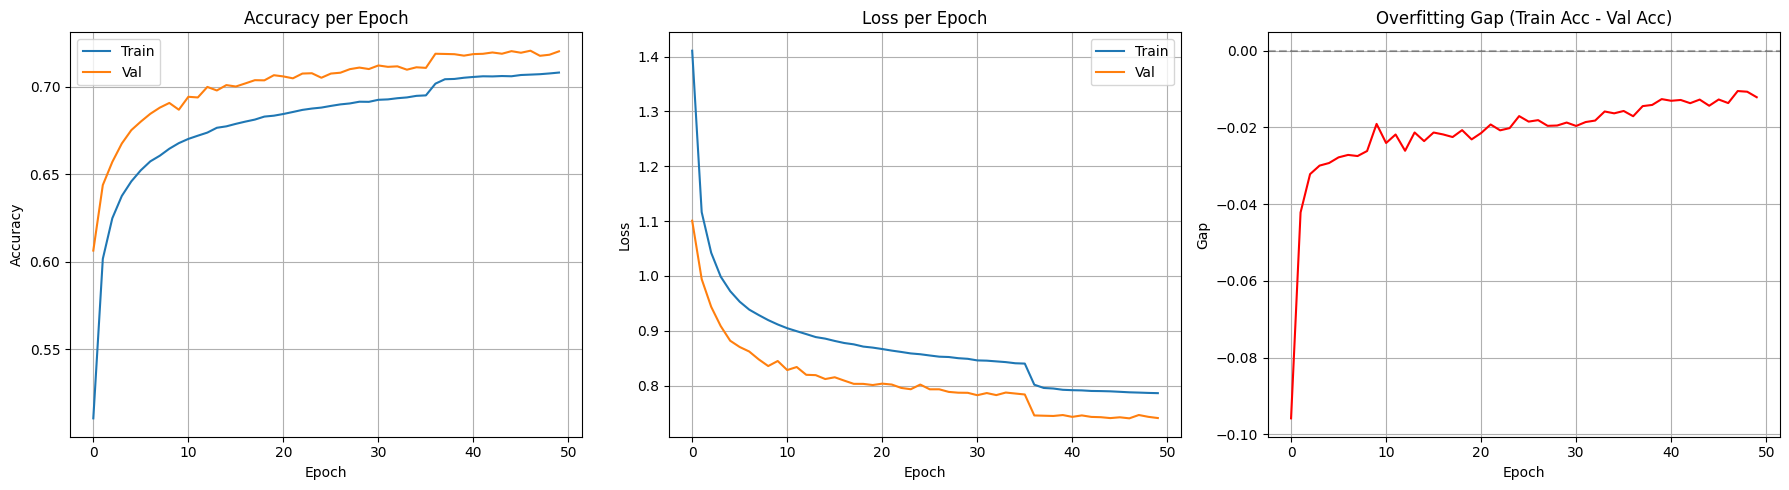


Best val accuracy: 0.7207 at epoch 47
Final train accuracy: 0.7082
Final val accuracy: 0.7203
Final gap: -0.0121


In [ ]:
# ==================== TRAINING INSIGHTS ====================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Accuracy per epoch
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Val')
axes[0].set_title('Accuracy per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# 2. Loss per epoch
axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Val')
axes[1].set_title('Loss per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# 3. Train vs Val accuracy gap (overfitting indicator)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
gap = [t - v for t, v in zip(train_acc, val_acc)]
axes[2].plot(gap, color='red')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[2].set_title('Overfitting Gap (Train Acc - Val Acc)')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Gap')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('training_plots.png', dpi=150)
plt.show()

# Print key stats
best_epoch = val_acc.index(max(val_acc))
print(f"\nBest val accuracy: {max(val_acc):.4f} at epoch {best_epoch + 1}")
print(f"Final train accuracy: {train_acc[-1]:.4f}")
print(f"Final val accuracy: {val_acc[-1]:.4f}")
print(f"Final gap: {gap[-1]:.4f}")

# Watch one game with full board output
result, n_moves = play_one_game_cnn_vs_mcts(
    model,
    cnn_color='plus',
    mcts_nsteps=500,
    verbose=True
)
print(f'\nResult: {result} in {n_moves} moves')